# Making SAFE More Secure

As discussed in the Section ..., it may be desirable to make the SAFE Protocol more secure against privacy-invasing information flows that could result from the aggregator's knowledge of the interval `[-D, D]`. 

This notebook illustrates a way to make privacy-invading bound inferences on the private values of users via randomizing the `[-D, D]` on each protocl run. 

The intent is not to thorough or completely rigorous; each step in the suggested procedure will throw up a host of issues that, to fully resolve, would take us beyond the scope of the project. The aim is to sketch an approach and nudge in the direction of how to develop this approach fully to maximal security.

[add specific section]:# (add section in the above)

Comments will be made on the limits this randomization introduces.

## Randomization Algorithm

As described in Section ..., one particular information flow that a semi-honest aggregator could exploit to infer bounds on private values rests on their knowledge of the doubles interval `[-D, D]` they know users draw random shares from.

This suggests a way to make SAFE more secure: randomize `[-D, D]` in each protocol run such that the aggregator would not be able to leverage knowledge of `[-D, D]` to make those inferences.

One way to do this would be to:
* Assume all users begin with some shared secret seed
* Using this shared seed, they generate a bit sequence using some given Pseudorandom Generator
* Map this bit sequence to a real value using some deterministic algorithm
* Use this real value as `D` in the `[-D, D]` interval.

The effcet of this will be that each protocl run executes with a `D` value the aggregator is not able to know, thus preventing inferences on the basis of `[-D, D]`.

Let us consider this procedure in greater detail. 

## Shared Secret Seed

Pseudorandom Generators (PRNG) are algorithms that generate a sequence of numbers that approximate a sequence of truly random numbers.{cite}`wiki:Pseudorandom_number_generator`. They are 'pseudorandom' because the sequence they generate is entirely determined by the initial seed value that is passed in. This means that if users use the same seed for the same PRNG, each time they invoke the PRNG, they will end up with the same output. Mapping this output to a real value, they can use this to set the `[-D, D]` interval from which they draw their random shares.

For this to achieve the intended effect of making the SAFE protocol more secure, a few conditions must be met:
* users must have a shared secret seed that the aggregator does not learn of
* users must use the same PRNG
* there must be an effective way to map the output of a PRNG to a real value suitable for use as the `D` value

### Distributing A Shared Secret Seed

Unfortunately, considering this first step takes us to a host of issues that we must consider. These issues relate to the general problem of secret establishment among many (i.e., more than two parties).

In this section, we will consider a variety of protocols for establishing the shared secret seed. 

Ultimately, no protocol comes without limitations and additional complexities. However, these are important considerations when deciding whether or not the greater security afforded by this proposed algorithm is worth the costs.

The following subsections will discuss various protocols. To skip ahead to a tentative decision and proceed with see the rest of the procedure, click [here](#shared-pseudorandom-generator--getting-a-real)

#### Diffe-Helman Key Exchange

Let us first consider how users might establish a secret seed by via communicating with one another.

To do this, we can first consider the Diffe-Helman Key Exchange. We will see that this protocol in its simplest form is not a viable solution,however, it is worth explicating and considering it first as it will raise certain issues and themes that will be picked up in subsequent protocols.

The Diffe-Helman Key Exchange is a means for two parties to establish some secure key in an insecure channel. This section's basic description of the protocol relies on {cite}`wiki:Diffie–Hellman_key_exchange`

##### Two Users 

For instance, suppose we have just two users in engaged in the SAFE protocol run, Alice and Bob. 

Both users publically agree on a $p$ and $g$ value, where $p$ is some prime and $g$ is the primitive root modulo $p$ or *group generator* for the multiplicative group of integers modulo $p$. 

Both Alice and Bob each choose some secret integer. Let $a$ denote Alice's secret and $b$ denote Bob's secret.

Alice computes $A = g^a  \space mod  \space p$ and sends $A$ to Bob, while Bob computes $B = g^b  \space mod  \space p$ and sends $B$ to Alice,

Then, Alice computes $B^a  \space mod \space p$ and Bob computes $A^b  \space mod  \space p$.

Becuase

$$
(g^a mod p)^b mod  \space p = (g^b mod p)^a mod  \space p 
$$

, both Alice and Bob would have arrived at the same value, $S$.

Even if the aggregator knows $g$, $p$, $A$ and $B$, it is very hard for them to derive the $S$ that Alice and Bob now share, so long as $a$ and $b$ remain hidden.

How hard is 'very hard'? The hardness of deriving $S$ consists in solving the *discrete logarithmic problem*, a problem deemed very hard for even modern supercomputers.

##### $N$ (where $N > 2$) Users

Of course, our use case is not likely to involve just two users, but many, many more. Is such a protocol scalable?

Assuming we try to simply scale the bare version of the protocol, we end up with a fairly untenable growth in complexity. More specifically, with $N$ users, each user will do $N$ exponentiations, meaning that there'll be a total of $N^2$ exponentiations for $N$ users.{cite}`se:generalize-diffe-helman`

An exponential growth in operations is probably undesirable even if the use-case is constrained to a relatively small scale. So, let us consider alternative protocols.

##### Using a Key Distribution Protocol

An alternative to having each user communicate with every other user is to designate some trusted server or chairman who distributes the secret seed to each user. However, this, among other things, merely introduces another third party and for whom undesirable information flows (assuming a semi-honest model) could result from. So, this option is a non-starter. 

##### Using A Key Agreement Protocol

One alternative protocol comes from {cite}`10.1093/comjnl/bxh111`. Tseng presents a multi-party key agreement protocol which allows $N$ users to collaboratively establish a common key without a designated chairman. This protocol is used to establish a common key in the context where there are 

The general idea behind the protocol is this: each user begins with two broadcast round. In each broadcast round, they calculate some random variable labelled with their user-id and send it to all other participants. The results of the first broadcast round are used to calculate the results distributed during the second broadcast round.

After receiving the second broadcast round variates from all other users, each user can compute two checks to see if there is any malicious participant in the protocol run. This check is user-specific, so pinpointing who the malicious participant is can be done. However, to save computational costs, users could instead bypass these initial checks and compute the common key $K$ according to some formula. This would be what happens if the two checks raise no issues anyway.

Then, they check if they can decrypt encrypted conference messages. If not, then there is a malicious particpant who has disrupted the conference and they must run the fault deduction procedure, and oust the malicious participant. If userse can decrypt conference messages using the constructed key $K$, that means there are no malicious participants in this conference round.

Tseng proves that the total computational cost of this protocol for each participant is $O(N)$ for $N$ participants, resistant to malicious participants. Moreover, number of messaging rounds and message size stay constant as $N$ grows. (ibid., 477)  

##### Usable in SAFE?

As promising as this protocol is, there are some things to consider with applying it in the SAFE protocol, and particularly for our use-case.

It is stipulated in Tseng's protocol that each user knows that set $U$ where $U$ is the set of initial participants wanting to generate the common conference key. (ibid., 471) However, this raises another general issue to reckon with in key distributions: authentication. Even assuming that we set up the infrastructure and resources required for communication, how do users know that those participating in the conference are in fact users? How do they know the aggregator is not included in the conference?

Tsung states that this protocol is a non-authenticated multi-party key agreement, which, "by its very nature cannot provide provide participant and message authentication, so it must rely on the authenticated network channel, or use another scheme to provide authentication." (ibid., 471) So, one way forwad is to assume that the users are part of an authenticated broadcast channel, and thus that it is secure against an impersonating aggregator (ibid.). Or, as suggested by Teng (ibid), one could apply the compiler presented in {cite}`10.1007/978-3-540-45146-4_7`. This compiler "transforms any group key-exchange protocol secure against a passive eavesdropper to an authenticated protocol which is secure against an active adversary who controls all communication in the network." (ibid., 110)

So, the problem of authentication is not insurmountable. But, either way, it's clear that trying to run this introduces some additional complexities, which will need to be weighted against other constraints. 

Another key consideration for its use in SAFE is that there aren't any conference messages for users to decrypt anyway. Instead, all that is needed is for users to generate some common seed.

Assuming a semi-honest model (which is what SAFE assumes), this is tenable because all users will conform to the protocol and compute the secret key accordingly. So, we could use the operations proposed in the paper to generate the requisite seed.

[even though Dr Huth has responded and given a suggestion, I don't think I'm going to take it up]:# (doesn't seem like a non-communication style is feasible)

##### Further Work

A fuller and more rigorious analysis of the various issues would be in order if one really were pressed to ensure both the scalability an security of this procedure run over the SAFE protocol. That is beyond the scope of this project, so I defer it for future work.

We have from {cite}`10.1093/comjnl/bxh111` a viable protocol for our purposes, so I will work simply assume that the $N$ users have established the secret seed by the means of the key agreement protocol, and consider the next step.


## Shared Pseudorandom Generator & Getting A Real

The distribution of the shared PRNG is far simpler than the distribution of the secret seed, since it can be public knowledge. It is acceptable that the aggregator knows what is the pseudorandom generator in use, so long as the seed parameter remains secret.

### Picking a Pseudo-Random Generator

One possible pseudorandom generator that could be used is the well-known Linear Congruential Generator (LCG).

A Linear Congruential Generator is an algorithm that yields a sequence of random numbers calculated via the following recurence:{cite}`wiki:Linear_congruential_generator`

$$
X_{n+1}=X_n*a+c \space (mod m)
$$.

$X_0$ is the seed or "start value".

Crucial to the quality of these PRNGs are the parameters $a$ (the multiplier), $c$ (the increment), and $m$ (the modulo).

Here we rely on {cite}`DBLP:journals/corr/abs-2001-05304` for recent guidance on judicious paramter values and the decision to use an LCG.

As they note, while LCGs have known defects, these can be mitigated if used in conjunction with other PRNGs or fed into some output function. (ibid. 2) For the kind of LCGs we have in mind here, namely where LCGs with multiplieres are $w$-bit and $m = 2^{2w}$, "it is now well undestood that LCGs of this kind should not be used in isolation, but rather as components of composite (or combined) PRNGs" (ibid.)

LCGs have the desriabel features of "speed and simplicity, as well as a substantial accured body of mathematical analysis", they can help to mitigate for the various costs raised from step 1 above (generating the shared secret seed). 

Configuring more robust PRNG combinations or compositions is deferred to further work. As the below plot shows, a simple LCG can generate a sequence that can make simple inferences on the `D` value untenable. 

Here is an example plot of the values generated by an LCG:

<Figure size 432x288 with 0 Axes>

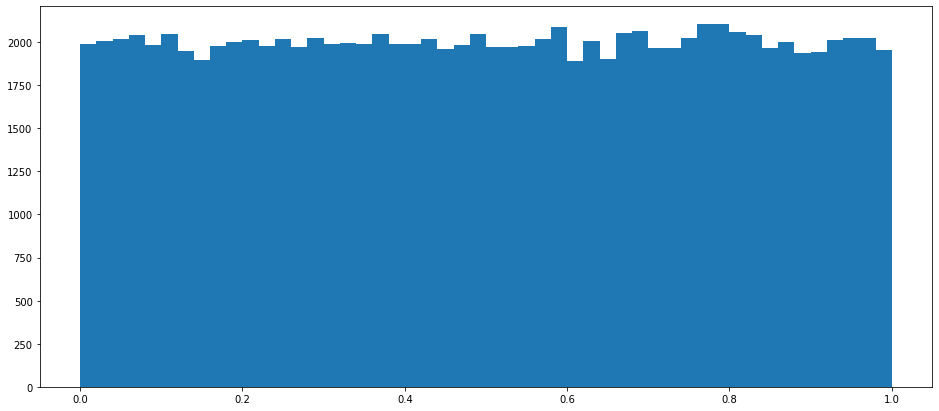

In [1]:
"""
*    Title: LCG Generator Source Code
*    Author: Sebastià Agramunt Puig 
*    Date: 2021
*    Code version: (Git Commmit SHA) e76ebc56e2642de126600fc3eee50b5a1ec2e48b  
*    Availability: https://github.com/OpenMined/courses/blob/f23c6d2b7a27afd7fbfd683c8fd05ca0df9925ec/cryptography/notebooks/Pseudorandom_Generators.ipynb
"""

a = 1664525
c = 1013904223
m = 2**32

def lcg(x0: int, a: int, c: int, m: int) -> int:
    return (x0*a+c)%m

x0 = 433

l = []

xn = x0
for _ in range(100000):
    xn = lcg(xn, a, c, m)
    l.append(xn/m)

import matplotlib.pyplot as plt

plt.clf()
fig = plt.figure(figsize=(16,7))
plt.hist(l, bins=50)
plt.show()

The y-axis represnts frequencies of generated values-- the flat distribution is indicative of randomness approximation.

Of course, protection against mere 'eyeballing' is far from robust security. But, following the guidance gestured at above, a more robust PRNG can be constructed.

---

Suppose then that we have some public PRNG and a shared secret seed for that PRNG among the users. There is just one more step for users to have randomized `D` values-- we need to convert the output of the PRNG to a float. 

## Deriving Random D values From PRNG Output

Consider the first 10 outputs of the PRNG coded above:

In [2]:
"""
* code source: ibid.
"""

xn = x0
for _ in range(10):
    xn = lcg(xn, a, c, m)
    print(xn)

1734643548
2376393483
1280826606
2989096821
4140206672
1634720111
4220925954
1435670393
3356220036
1962779667


One way to map these integer outputs is to use their bit representations to derive IEEE Single-Precision Floats.

We can see their bit representations here:

In [3]:
xn = x0
for _ in range(10):
    xn = lcg(xn, a, c, m)
    print(f'{xn}: {bin(xn)}, bit-length: {len(bin(xn)[2:])} ')

1734643548: 0b1100111011001001000111101011100, bit-length: 31 
2376393483: 0b10001101101001001110001100001011, bit-length: 32 
1280826606: 0b1001100010101111101110011101110, bit-length: 31 
2989096821: 0b10110010001010011111111101110101, bit-length: 32 
4140206672: 0b11110110110001101000101001010000, bit-length: 32 
1634720111: 0b1100001011011111101100101101111, bit-length: 31 
4220925954: 0b11111011100101100011100000000010, bit-length: 32 
1435670393: 0b1010101100100101001011101111001, bit-length: 31 
3356220036: 0b11001000000010111101101010000100, bit-length: 32 
1962779667: 0b1110100111111011010010000010011, bit-length: 31 


The IEEE Single-Precision format consists of 32-bits. For numbers that have 32 bit representations, we can simply create floats by taking the 32 bits as represented by the 1-8-23 bit split between the sign, exponent and fraction, and then getting the float represented by those 32 bits.

For numbers that don't have 32 bit representations, we can pad the bits with either a 0 or 1, and then proceed with this algorithm.

Let's see how this might work in practice:
1. First, get the binary string representation of the PRNG's output
2. Then, we convert that binary string representation into a float of the required format
3. The **absolute** value of the float returned will be `D`

In Python:

In [9]:
"""
* Key Resources: (code adapted from)
# https://stackoverflow.com/questions/8751653/how-to-convert-a-binary-string-into-a-float-value
# https://stackoverflow.com/questions/25099626/convert-scientific-notation-to-float
# https://stackoverflow.com/questions/30971079/how-to-convert-an-integer-to-a-list-of-bits
"""

from codecs import decode
import struct

def int_to_bin(num: int) -> str:
    """ Convert integer to binary string representation. """
    list_of_bits = [1 if num & (1 << (31-n)) else 0 for n in range(32)]
    string_version = ''.join([str(bit) for bit in list_of_bits])
    return string_version

def bin_to_float(byte_string: str) -> str:
    """ Convert binary string to a float. """
    float_bytes = int(byte_string, 2).to_bytes(4, 'big')  
    # see https://docs.python.org/3/library/struct.html for manipulation of params
    float_string =  format(struct.unpack('>f', float_bytes)[0], 'f')
    return float(float_string)

def int_to_float(num: int) -> float:
    bits = int_to_bin(num)
    return abs(bin_to_float(bits))

# Test example
num = 4140206672
print(f'For the output: {num}, we have the float: {int_to_float(num)}')


For the output: 4140206672, we have the float: 2.0134376733753925e+33


We now have a way for users to arrive at the same `D` value to run the protocol with, while the aggregator will not be able to reconstruct this same `D` value so long as the shared seed value remains secret.

## Putting Everything Together

Let's bring everything together and see our procedure generate a few `D` values. We will generate 10.

In [17]:
# assume users have random_seed

random_seed = 165343 # any value < m is fine

a = 1664525
c = 1013904223
m = 2**32

# generate 10 random outputs

random_outputs = []

xn = random_seed
for _ in range(10):
    xn = lcg(xn, a, c, m)
    random_outputs.append(xn)

# convert to D values

D_values = [int_to_float(output) for output in random_outputs]

for output, D in zip(random_outputs, D_values):
    print(f'Output: {output}; D Value: {D}')

# why are there 0 values?


Output: 1353554354; D Value: 23300247552.0
Output: 2195631465; D Value: 0.0
Output: 2316736436; D Value: 0.0
Output: 278552451; D Value: 0.0
Output: 3927899910; D Value: 4.80536484081769e+25
Output: 1630816941; D Value: 2.0786218064984356e+20
Output: 1287433256; D Value: 98918720.0
Output: 511943015; D Value: 0.0
Output: 4269551514; D Value: 8.3803154095307225e+37
Output: 1237236273; D Value: 1562438.125


### Commment

I'm unsure why there are 0 and sometimes `nan` values, but an immediate fix would be to simply regenerate an output if the `int_to_float` procedure returns a zero or a `nan`.



## Test Runs of SAFE With Random `[-D, D]` Interval

Now, let's consider the perspective of the aggregator trying to make bound inferences on a user's private value given 10 runs of the SAFE Protocol with randomized `D` values. 

We will look at the obfuscated feature vector he receives in each round and consider whether information flows of the kind mentioned in Section ..., are still possible.


### Bibliography

[needed to include this bibliography tag to get citations to work: found that from https://github.com/executablebooks/jupyter-book/issues/1662]:# (why this bibliography code block is needed)

```{bibliography}
```